In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip -qq "/content/gdrive/MyDrive/denoising-dirty-documents.zip"

In [3]:
!unzip -qq "/content/train.zip"

In [4]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [5]:
%matplotlib inline

(420, 540)


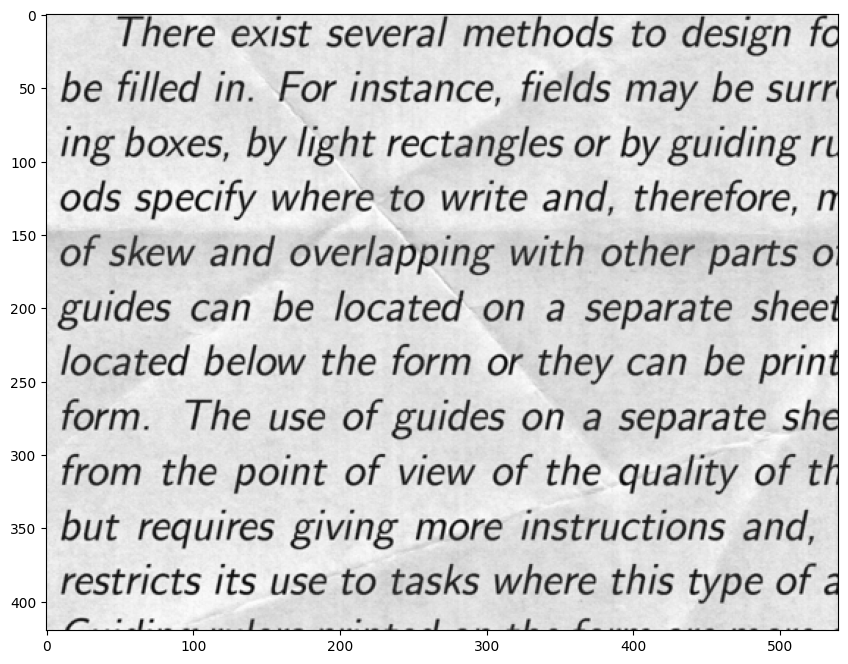

In [6]:
plt.figure(figsize=(20,8))
img = cv2.imread("/content/train/101.png", 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [7]:
!unzip -qq "/content/test.zip"

In [8]:
!unzip -qq "/content/train_cleaned.zip"

In [9]:
TRAIN_IMAGES = glob.glob('../content/train/*.png')
CLEAN_IMAGES = glob.glob('../content/train_cleaned/*.png')
TEST_IMAGES = glob.glob('../content/test/*.png')

In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list


In [11]:
x_train = load_image(TRAIN_IMAGES)

In [12]:
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)


In [13]:
print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [14]:
def train_val_split(x_train, y_train):
    #무작위 난수
    rnd = np.random.RandomState(seed=42)
    #무작위로 학습데이터를 섞기기
    perm = rnd.permutation(len(x_train))
    #무작위로 섞인 데이터에서 80%에 해당하는 인덱스를 선택
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]


In [15]:
x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)

In [16]:
print(x_train.shape, x_val.shape)

(115, 258, 540, 1) (29, 258, 540, 1)


In [17]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258  # 오타 수정: img.rows -> img_rows
        self.img_cols = 540  # 오타 수정: img.cols -> img_cols
        self.channels = 1  # 오타 수정: channel -> channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(lr=0.001)

        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()

    def build_model(self):
        input_layer = Input(shape=self.img_shape)

        #encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        # MaxPooling2D: 이미지를 압축하는 방법
        h = MaxPooling2D((2, 2), padding='same')(h)

        #decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        # upsampling은 차원을 확장하는 것
        h = UpSampling2D((2, 2))(h)
        # 1은 채널 개수 (3, 3) 합성곱 커널 크기
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)

    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       #patience =5 -> 성능개선이 멈추고 5번 더 학습해봄
                                       patience=5,
                                       verbose=1,
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train, batch_size=batch_size,
                                             epochs=epochs, validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 258, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 258, 540, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 270, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 129, 270, 64)      36928     
                                                                 
 up_sampling2d (UpSampling2D  (None, 258, 540, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 258, 540, 1)       577   

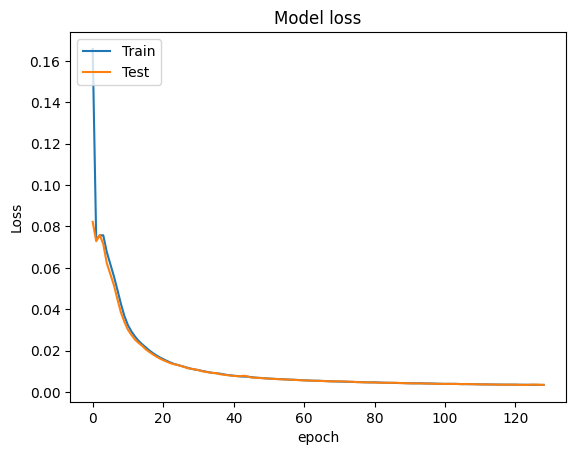

In [18]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=200, batch_size=20)


In [19]:
preds = ae.eval_model(x_test)

3/3 [==============================] - 3s 407ms/step


In [33]:
preds.shape

(72, 258, 540)

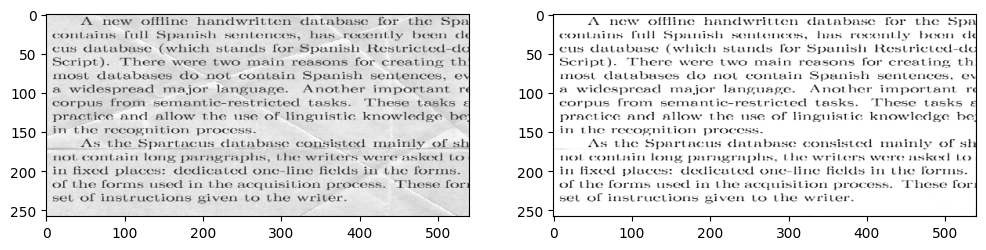

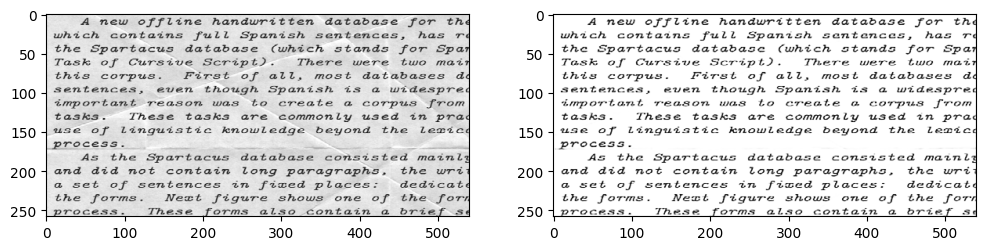

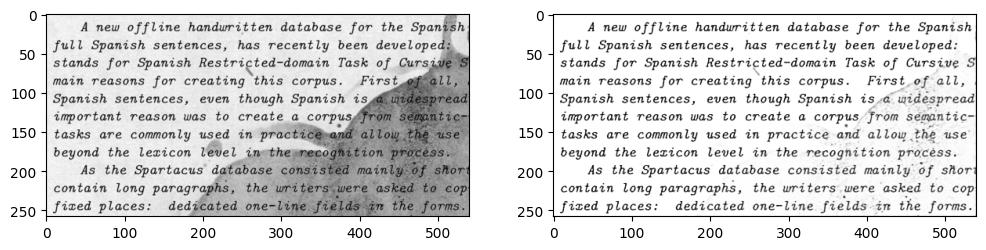

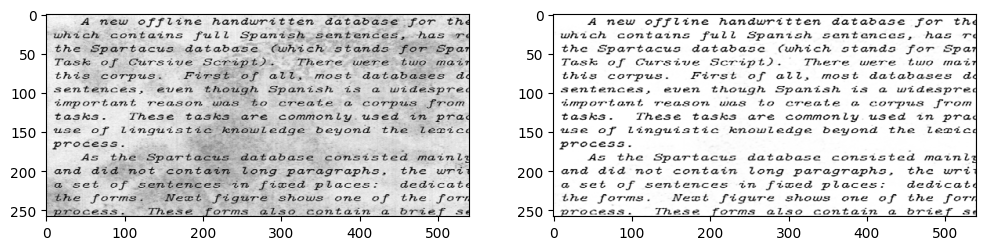

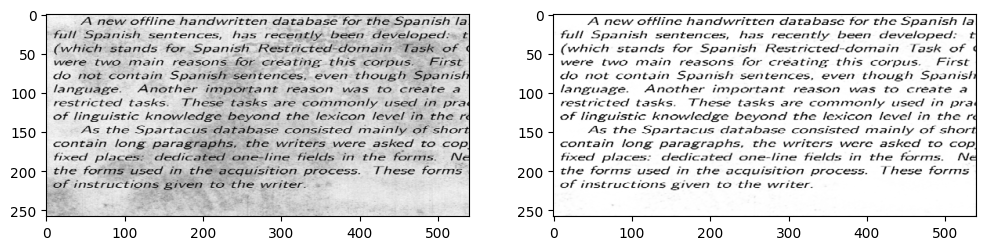

In [39]:
import os
import cv2

# 디렉토리 생성
#경로상에 image라는 파일을 미리 만들어야한다.
output_dir = '/content/image'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(5):
    preds_0 = preds[i] * 255.0
    preds_0 = preds_0.reshape(258, 540)
    x_test_0 = x_test[i] * 255.0
    x_test_0 = x_test_0.reshape(258, 540)
    
    plt.figure(figsize=(12, 6))
    
    # 첫 번째 서브플롯에 x_test_0 출력
    plt.subplot(1, 2, 1)
    plt.imshow(x_test_0, cmap='gray')
    
    # 두 번째 서브플롯에 preds_0 출력
    plt.subplot(1, 2, 2)
    plt.imshow(preds_0, cmap='gray')
    
    plt.show()

    # x_test_0 이미지를 output_images 디렉토리에 저장
    cv2.imwrite(os.path.join(output_dir, f'x_test_0_{i}.png'), x_test_0)
